In [1]:
%pylab inline
import sys; sys.path.insert(0, "../")
import numpy as np
import time

from pandas import DataFrame
import seaborn as sns

from emcee.autocorr import *
from ensemble_sampler import *

Populating the interactive namespace from numpy and matplotlib


# Example of sampling from a multivariate gaussian

## True distribution

In [2]:
dim = 2
nwalkers = 4
niters = 100000

In [3]:
mu = np.zeros(dim)
cov = np.identity(dim)

t_dist = MultivariateGaussian(cov=cov, mu=mu, dim=dim)

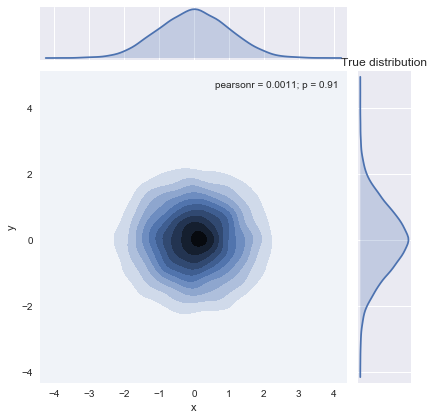

In [14]:
data = np.empty([10000, 2])
for i in range(10000):
    data[i] = np.random.multivariate_normal(mean=mu, cov=cov)
df = DataFrame(data, columns=['x', 'y'])
sns.jointplot(x='x', y='y', data=df, kind='kde')
sns.plt.title('True distribution')

## Only ensemble, proposal scale=0.5. 

In [21]:
save_dir = './data/'
title = 'ensemble_only'

In [22]:
proposal = WalkMove(ensemble=True, scale=0.5)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
sampler.run_mcmc(niters, batch_size=1, p0=np.random.randn(dim*nwalkers).reshape([nwalkers, dim]), 
                verbose=False, store=True, save_dir=save_dir, title=title)
hist = sampler.history
end = time.time()

In [17]:
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

finishes in about 109.79 seconds
auto-correlation time: [ 50.02347806  55.86068685]


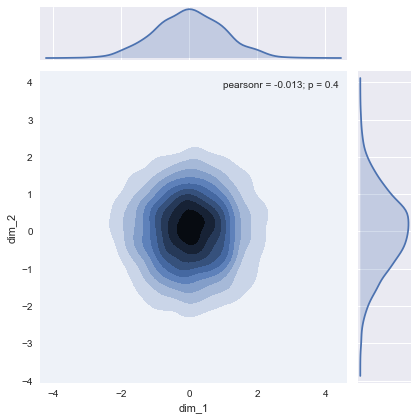

In [18]:
chain = hist.get_flat('chain')
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[::100, 0], chain[::100, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df, kind='kde')

## pCN, proposal beta=0.2. 

In [9]:
niters = 100000

proposal = WalkMove(ensemble=True, beta=0.2)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
sampler.run_mcmc(niters, batch_size=1, random_start=True, store=True, store_every=50000, title='test')

end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

removing ./results/test.hdf5...
saving to ./results/test.hdf5...
saving to ./results/test.hdf5...
finishes in about 119.97 seconds
The chain is too short to reliably estimate the autocorrelation time


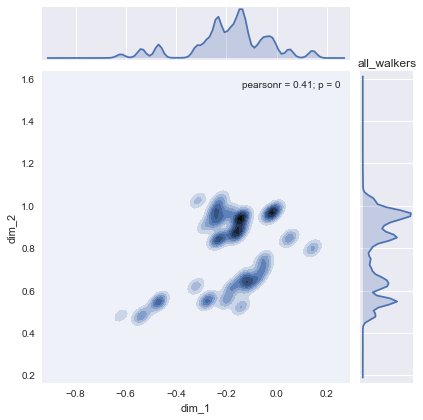

In [10]:
chain = sampler.history.get_flat('chain', get_every=100)
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[:, 0], chain[:, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df, kind='kde')
sns.plt.title('all_walkers')

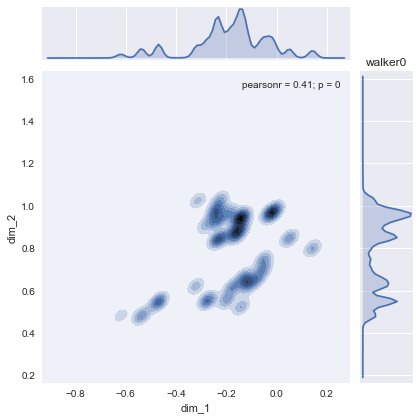

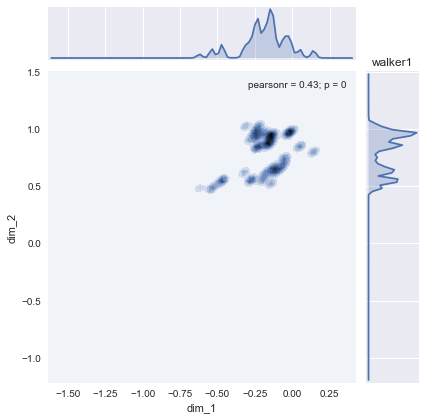

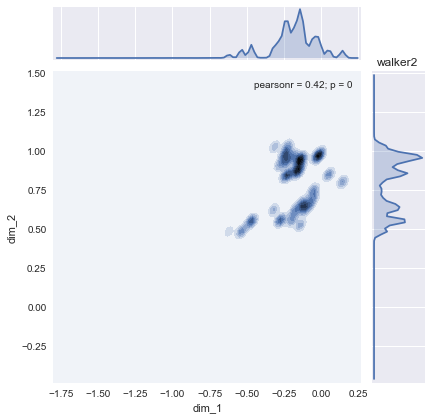

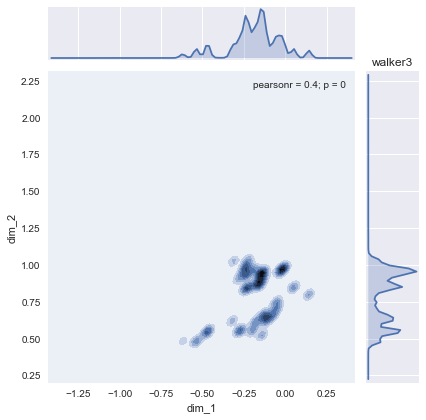

In [11]:
chain = sampler.history.get('chain')
x, y = ['dim_1', 'dim_2']
for i in range(nwalkers):
    df = DataFrame(np.vstack([chain[i, :, 0], chain[i, :, 1]]).T, columns=[x, y])
    sns.jointplot(x=x, y=y, data=df, kind='kde')
    sns.plt.title('walker%s' % i)

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


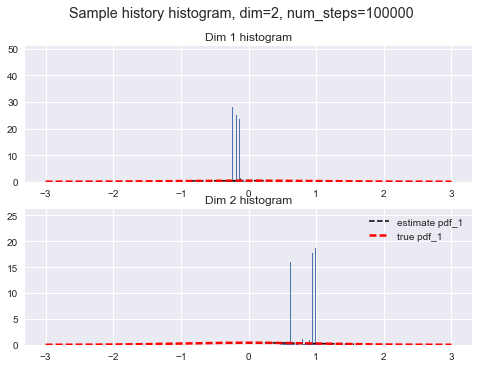

In [12]:
import math
def pdf(x):
    return np.exp(-x**2 / 2.0) / np.sqrt(2*math.pi)

chain = sampler.history.get_flat('chain', get_every=100)

n = 2
num_steps = len(chain)
num_bins = int(num_steps * 0.01)

fig, axs = plt.subplots(2, 1)
fig.suptitle("Sample history histogram, dim=%s, num_steps=%s" % (dim, num_steps))
for i in range(2):
    idx = i if n == 1 or n == 2 else (i // 2, i % 2)
    _, bins, _ = axs[idx].hist(chain[:, i], num_bins, normed=1)
    
    y = pylab.normpdf(bins, 0, 1)
    l = axs[idx].plot(bins, y, 'k--', lw=1.5, label='estimate pdf_%s' % i)
    
    x = np.linspace(-3, 3, num_bins)
    p = axs[idx].plot(x, pdf(x), 'r--', lw=2.5, label='true pdf_%s' % i)
    pylab.legend()
    axs[idx].plot()
    axs[idx].set_title("Dim %s histogram" % int(i+1))

In [13]:
from emcee.autocorr import *

In [15]:
def plot_acf(chain, max_lag=1000, mean_first=False):
    if mean_first:
        acf = function(np.mean(chain, axis=0))
        title = 'Mean of walkers first'
    else:
        acf = np.zeros_like(chain)
        for i in range(acf.shape[0]):
            acf[i] = function(chain[i])
        acf = np.mean(acf, axis=0)
        title = 'Mean of acf'
    data = DataFrame(acf[:max_lag], columns=['dim_1','dim_2'])
    ax = data.plot()
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax.set(xlabel='lag', ylabel='ACF', title=title)
    plt.show()

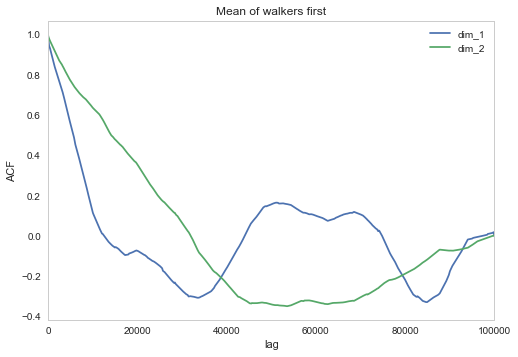

In [19]:
chain = sampler.history.get('chain')
plot_acf(chain, mean_first=True, max_lag=100000)

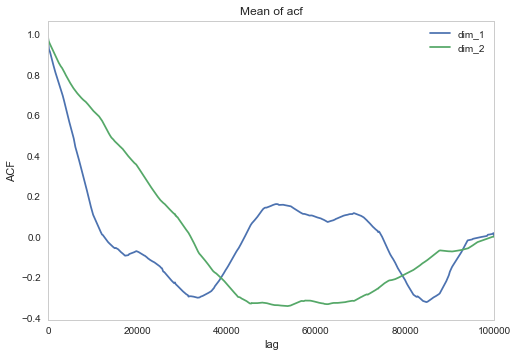

In [20]:
plot_acf(chain, mean_first=False, max_lag=100000)

In [ ]:
from matplotlib.animation import FuncAnimation
niters = 1000
proposal = WalkMove(beta=0.2)
sampler = Sampler(t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)
hist = sampler.sample(niters, random_start=True, per_walker=False)

visualizer = Visualizer(sampler.history, False, max_len=niters)
anim = FuncAnimation(fig=visualizer.fig, func=visualizer, init_func=visualizer.init,
                     frames=hist, interval=20, blit=True, save_count=niters)

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())

## "Pure pCN"

In [ ]:
dim = 2
nwalkers = 4
niters = 100000

proposal = PCNWalkMove(s=None, beta=0.3)
sampler = Sampler(dim=dim, t_dist=t_dist, proposal=proposal, nwalkers=nwalkers)

start = time.time()
sampler.run_mcmc(niters, batch_size=1, p0=np.random.randn(dim*nwalkers).reshape([nwalkers, dim]),
                 store=True, verbose=False, print_every=5000)
hist = sampler.history
end = time.time()
print 'finishes in about %.2f seconds' % float(end - start)
try:
    print 'auto-correlation time: %s' % sampler.auto_corr()
except AutocorrError, err:
    print err

In [ ]:
chain = hist.get_flat('chain')
x, y = ['dim_1', 'dim_2']
df = DataFrame(np.vstack([chain[::100, 0], chain[::100, 1]]).T, columns=[x, y])
sns.jointplot(x=x, y=y, data=df, kind='kde')